In [ ]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
import sympy as sp

NOTE TO SELF: Squeezed cat state i qutip, test nogle gates fra Olga's paper (nok også smart at gøre i qutip), og så var der noget reference paper fra Jonas, test GKP gates (fra det originale GKP paper?) Ellers bliv god til qutip    

In [25]:
hbar = 1
x = np.linspace(-8,8, 300)
p = np.linspace(-8,8, 300)

def a(N):
    """Create the annihilation operator for a harmonic oscillator."""
    return qt.destroy(N)

class sq_cat_state:
    def __init__(self, N, k=1, alpha=1, r = 0):
        self.N = N
        self.k = k
        self.alpha = alpha
        self.r = r

    def state(self):
        S = qt.squeeze(self.N, self.r)
        return S * (qt.coherent(self.N, self.alpha) + (-1)**self.k * qt.coherent(self.N, -self.alpha)).unit()
    
    def x(self):
        S = qt.squeeze(self.N, self.r)
        return S * np.sqrt(hbar/2) * (a(self.N) + a(self.N).dag()) * S.dag()
    
    def p(self):
        S = qt.squeeze(self.N, self.r)
        return S * 1j * np.sqrt(hbar/2) * (a(self.N).dag() - a(self.N)) * S.dag()
    

def bs(theta, state1, state2):
    # Get the operators for each mode
    x1 = qt.tensor(state1.x(), qt.qeye(state2.N))
    p1 = qt.tensor(state1.p(), qt.qeye(state2.N))
    x2 = qt.tensor(qt.qeye(state1.N), state2.x())
    p2 = qt.tensor(qt.qeye(state1.N), state2.p())
    
    # Create the beam splitter operator in joint space
    U = ((-1j * theta)/2 * (x1 * p2 - x2 * p1)).expm()
    
    # Create the joint state
    joint_state = qt.tensor(state1.state(), state2.state())
    
    # Apply the beam splitter
    return U * joint_state



Final state norm: 1.0
Measurement probabilities: [0.3002676791612301, 0.3006936747954602]


KeyboardInterrupt: 

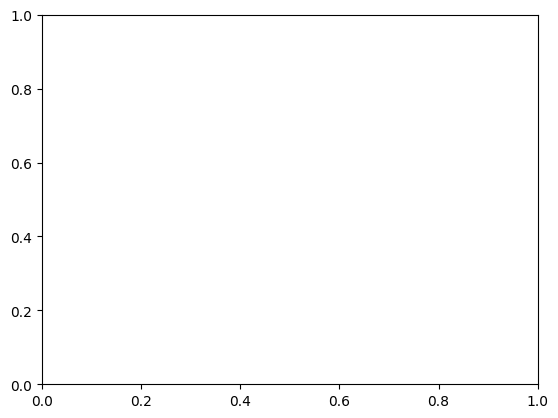

In [26]:
def normalized_x_measurement(state, x_val, N):
    """Projects onto |x=x_val⟩ with proper normalization"""
    x_state = qt.position(N, x_val)
    overlap = qt.tensor(qt.qeye(N), x_state.dag()) * state
    prob = overlap.norm()**2
    return (overlap/np.sqrt(prob)).unit() if prob > 1e-8 else None

def breeding(N, n, alphas=None, rs=None, ks=None, p_measured=0):
    """
    Args:
        N (int): Hilbert space dimension.
        n (int): Number of input states (breeding steps = n-1).
        alphas (list): Optional list of n coherent state amplitudes. Defaults to [1, ..., 1].
        rs (list): Optional list of n squeezing parameters. Defaults to [1, ..., 1].
        ks (list): Optional list of n parity values (0=even, 1=odd). Defaults to [1, ..., 1].
        p_measured (float): Momentum measurement result. Default 0.
        
    Returns:
        final_state (qt.Qobj): Conditional state of the last mode.
        measurement_probs (list): Probabilities of p_measured outcomes.
    """
    # Set defaults if not provided
    alphas = alphas if alphas is not None else [1.0] * n
    rs = rs if rs is not None else [1.0] * n
    ks = ks if ks is not None else [1] * n
    
    # Validate input lengths
    if len(alphas) != n or len(rs) != n or len(ks) != n:
        raise ValueError(f"Parameters must be lists of length {n}")
    
    # Initialize states with defaults or custom values
    states = [sq_cat_state(N, ks[i], alphas[i], rs[i]) for i in range(n)]
    
    current_state = states[0].state()
    measurement_probs = []
    
    for i in range(n-1):
        theta_i = np.arccos(1/(i+2))  # Reflectivity = 1/(i+2)
        output_state = bs(theta_i, states[i], states[i+1])
        
        # Measure mode 2 in p=p_measured
        p_state = qt.momentum(N, p_measured)
        projector = qt.tensor(qt.qeye(N), p_state.dag())
        unnormalized = projector * output_state
        prob = unnormalized.norm()**2
        measurement_probs.append(min(prob, 1.0))
        
        if prob < 1e-8:
            print(f"Warning: Near-zero probability at step {i}")
            return None, measurement_probs
        
        current_state = (unnormalized / np.sqrt(prob)).unit()
    
    return current_state, measurement_probs

# Parameters
N = 30
alphas = [1.0, 1.0, 1.0]    # Three coherent states
rs = [-0.5, -0.5, -0.5] 
ks = [1,1,1]    # Parities

# Run breeding protocol
final_state, probs = breeding(N, 3, alphas, rs)

# Results
print(f"Final state norm: {final_state.norm()}")
print(f"Measurement probabilities: {probs}")
qt.plot_wigner(final_state)  # Visualize the final state

In [27]:
from tqdm.notebook import tqdm  # For Jupyter notebooks
# from tqdm import tqdm  # For non-notebook environments

def breeding(N, n, alphas=None, rs=None, ks=None, p_measured=0):
    """
    Args:
        N (int): Hilbert space dimension.
        n (int): Number of input states (breeding steps = n-1).
        alphas (list): Optional list of n coherent state amplitudes. Defaults to [1, ..., 1].
        rs (list): Optional list of n squeezing parameters. Defaults to [1, ..., 1].
        ks (list): Optional list of n parity values (0=even, 1=odd). Defaults to [1, ..., 1].
        p_measured (float): Momentum measurement result. Default 0.
        
    Returns:
        final_state (qt.Qobj): Conditional state of the last mode.
        measurement_probs (list): Probabilities of p_measured outcomes.
    """
    # Set defaults
    alphas = alphas if alphas is not None else [1.0] * n
    rs = rs if rs is not None else [1.0] * n
    ks = ks if ks is not None else [1] * n
    
    # Validate inputs
    if len(alphas) != n or len(rs) != n or len(ks) != n:
        raise ValueError(f"Parameters must be lists of length {n}")
    
    # Initialize states
    states = [sq_cat_state(N, ks[i], alphas[i], rs[i]) for i in range(n)]
    
    current_state = states[0].state()
    measurement_probs = []
    
    # Progress bar for breeding steps
    for i in tqdm(range(n-1), desc="Breeding Progress", unit="step"):
        theta_i = np.arccos(np.sqrt(1/(i+2)))  # Reflectivity = 1/(i+2)
        output_state = bs(theta_i, states[i], states[i+1])
        
        # Measure mode 2 in p=p_measured
        p_state = qt.momentum(N, p_measured)
        projector = qt.tensor(qt.qeye(N), p_state.dag())
        unnormalized = projector * output_state
        prob = unnormalized.norm()**2
        measurement_probs.append(min(prob, 1.0))
        
        if prob < 1e-8:
            print(f"Warning: Near-zero probability at step {i}")
            return None, measurement_probs
        
        current_state = unnormalized.unit()
    
    return current_state, measurement_probs

In [31]:
# Parameters
N = 30
alphas = [1.0, 1.0, 1.0]    # Three coherent states
rs = [0.5, 0.5, 0.5]
ks = [1,1,1]    # Parities

# Run breeding protocol
final_state, probs = breeding(N, 3, alphas, rs)

# Results
print(f"Final state norm: {final_state.norm()}")
print(f"Measurement probabilities: {probs}")
# OOOOBS    Det tager lang tid (længere end udregningen) at udregne wigner functionen
WIG = qt.wigner(final_state, x, p) # Visualize the final state #

Breeding Progress:   0%|          | 0/2 [00:00<?, ?step/s]

Final state norm: 0.9999999999999998
Measurement probabilities: [1.0, 1.0]


In [32]:
Px = np.trapezoid(WIG, p, axis=0)  
Pp = np.trapezoid(WIG, x, axis=1)
vmin = np.min(WIG)
vmax = np.max(WIG)


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alexa\AppData\Local\Temp\ipykernel_28604\2942404279.py:15: SyntaxWarning: invalid escape sequence '\D'
  axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$".format(np.exp(-rs[0])))


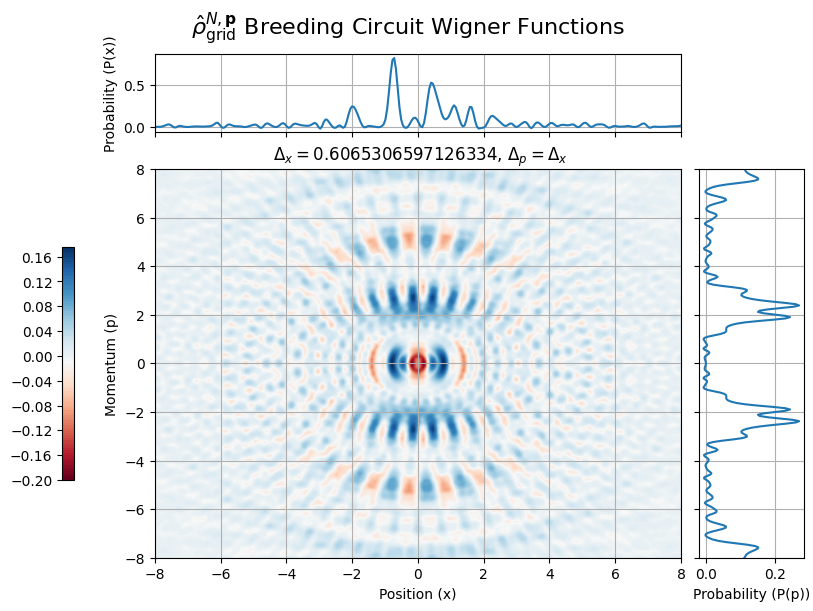

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True, gridspec_kw={"height_ratios": [0.2, 1], "width_ratios": [1, 0.2]}, sharex = "col", sharey = "row")

plt.suptitle(r"$\hat{\rho}_{\mathrm{grid}}^{N,\bf{p}}$ Breeding Circuit Wigner Functions", fontsize=16)

axs[0, 0].plot(x,Px)
axs[0, 0].set_ylabel("Probability (P(x))")
axs[0,0].grid()

#axs[0, 0].set_title("Top-left")

axs[0, 1].axis('off')  # disables axes for this cell

cf3 = axs[1,0].contourf(x, p, WIG, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)

axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$".format(np.exp(-rs[0])))
axs[1,0].set_xlabel("Position (x)")
axs[1,0].set_ylabel("Momentum (p)")
axs[1,0].grid()
fig.colorbar(cf3, ax=axs[1,0], location = 'left', shrink = 0.6)

axs[1, 1].plot(Pp,p)
axs[1, 1].set_xlabel("Probability (P(p))")
axs[1, 1].grid()
